# Quantum Machine Learning Workshop

### PyQuil implementation of the Data-Driven Quantum Circuit Learning (DDQCL) Algorithm 

Authors: Vicente Leyton-Ortega (ORNL) and Alejandro Perdomo-Ortiz
(Zapata Computing)

Summary: Quick (and probably suboptimal) implementation of DDQCL in pyQuil/Forest

In [24]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# NOTE: IF the next window doesn't run, open two terminals and run:
# qvm -S
# quilc -S

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [25]:
#load the necessary packages and libraries
from pyquil.quil import Program   
import pyquil.api as api
from pyquil.gates import *

from utils import *
import numpy as np
import matplotlib.pyplot as plt
from random import *
import itertools
from pso import PSO
import time

qvm = api.QVMConnection()  
PRECISION = 8
CLIP = 1e-8

### Bars & Stripes data set

Here we consider an $n \times m$ data set

<IPython.core.display.Javascript object>


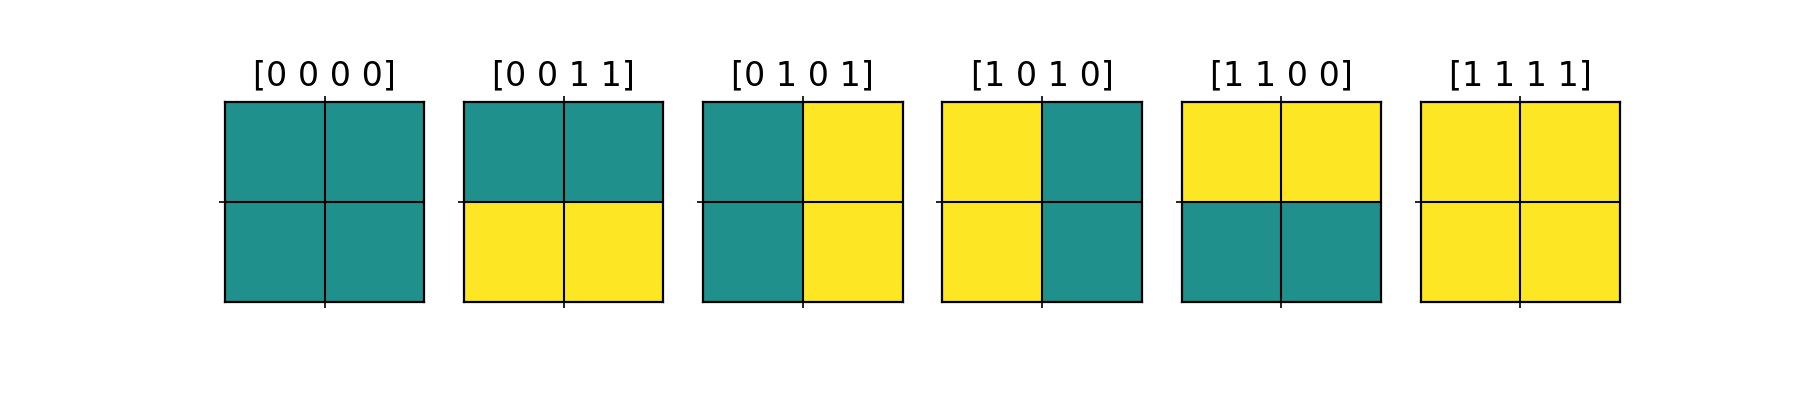

In [26]:
global n_qubits, hist_sample, n, m

n , m =  2, 2

bas = bars_and_stripes(n,m)

n_points, n_qubits  =  bas.shape

fig, ax_b = plt.subplots(1, bas.shape[0], figsize=(9,2))   #visualization of bars ans stripes data set

for i in range(bas.shape[0]):
    ax_b[i].matshow(bas[i].reshape(n, m), vmin=-1, vmax=1)
    
    ax_b[i].set_xticks([])
    ax_b[i].set_yticks([])
    
    ax_b[i].set_xticks([0.5], minor=True);
    ax_b[i].set_yticks([0.5], minor=True);
    
    ax_b[i].set_title(bas[i])
    ax_b[i].grid(which='minor', color='black', linestyle='-', linewidth=0.75)
    
'''sample distribution'''
hist_sample = get_histogram(bas)

### Topologies

In [27]:
import networkx as nx 

edges_all_connected = []
edges_star          = []
edges_line          = []

''' line topology'''
for i in range(n_qubits-1):
    connections = [i,i+1]
    edges_line.append(connections)


'''star topology'''
for i in range(1,n_qubits):
    connections = [0,i]
    edges_star.append(connections)


'''all connected topology'''
for i in range(n_qubits-1):
    for j in range(i+1,n_qubits):
        connections = [i,j]
        edges_all_connected.append(connections)

# Or build any other you would like to explore. For example, ring topology?
        
        
'''lets define a little function for the connections'''
def top(x):
    if x == 0:
        edges = edges_line
    if x == 1: 
        edges = edges_star
    if x == 2:
        edges = edges_all_connected
    return edges

### Circuit parameters

In [28]:
global n_top, single_g, entangling_g, n_layers, dimension, machine
global min_bounds, max_bounds, n_rotations, init_state, n_measurements, q_arrange 

'''define the topology and initial state'''
n_top = 2             # options: 0 - line, 1 - star,  2 - all connected 
init_state = 'zero'   # options: zero and hadammard

'''define single and entangling gates'''
single_g      =  ['RY','RZ']   
entangling_g  =  ['YY']       # options YY, ZZ, CPHASE -- the entangling gate can be modify in the circuit           

'''define the number of layers'''
n_layers = 2

'''number of parameters'''
n_rotations   = len(single_g)
even_n_layers = int(np.floor(n_layers/2))
odd_n_layers  = n_layers - even_n_layers
if single_g[0] == 'RZ' and init_state == 'zero':
    dimension     = (n_rotations*odd_n_layers-1)*n_qubits + len(top(n_top))*even_n_layers  
else:
    dimension     = (n_rotations*odd_n_layers)*n_qubits + len(top(n_top))*even_n_layers

### Quantum Circuit: Instructions to the quantum computer

In [29]:
def circuit(angles):
    
    if init_state == 'zero' :
        C = Program([I(i) for i in range(n_qubits)])
    elif init_state == 'hadamard':
        C =  Program([H(i) for i in range(n_qubits)])
    
    i = 0
    
    for ly in range(1, n_layers + 1):
        if ly % 2 == 1:                       #single gates are only in odd layers
            for qb in range(n_qubits):
                for op in single_g:
                    
                    x = angles[i]*np.pi       #rotating angles are written in units of pi 
                    gate = (op + "("+str(x)+")",qb)
                    C.inst(gate)
                    
                    i+=1                      #now it will call the next element in angles
                                        
        else:
            for qb_qb in top(n_top):
                if entangling_g[0] == 'YY':
                    
                    x = angles[i]*np.pi  #entangling angles are written in units of 2*pi
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    
                    C.inst(CNOT(idx1,idx2))
                    C.inst(RY(x,idx2))
                    C.inst(CNOT(idx1,idx2))
                            
                    i+=1
                    
                elif entangling_g[0] == 'ZZ':  #ZZ(theta,1,2) = CNOT(1,2) RZ(2 theta,2) CNOT(1,2), - pi < 2 theta < pi
                    
                    x = angles[i]*np.pi     # theta = x*pi/2, then -1 < x < 1
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    
                    C.inst(CNOT(idx1,idx2))
                    C.inst(RZ(x,idx2))
                    C.inst(CNOT(idx1,idx2))
                    
                    i+=1 
                    
                elif entangling_g[0] == 'XX':  #XX(theta,1,2) = CNOT(1,2) RX(2 theta,2) CNOT(1,2), - pi < 2 theta < pi
                    
                    x = angles[i]*np.pi     
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    
                    C.inst(CNOT(idx1,idx2))
                    C.inst(RX(x,idx2))
                    C.inst(CNOT(idx1,idx2))
                    
                    i+=1 
                                               ## we can define more entangling gates!
                else:
                    
                    x = angles[i]*np.pi 
                    idx1 = qb_qb[0]
                    idx2 = qb_qb[1]
                    gate = (entangling_g[0] + "("+str(x)+")",idx1,idx2)
                    C.inst(gate)
                    
    wf         =  qvm.wavefunction(C)     #get the output circuit wavefunction
    probs_dist =  wf.get_outcome_probs()  #get the probability distribution --- be careful it is a dict
    probs      =  list(range(2**n_qubits))
    
    '''here we extract the distribution values from the dict'''
    for i in range(2**n_qubits):

        aa = str(np.binary_repr(i,n_qubits))
        probs[i]=probs_dist[aa]
        
    assert(round(sum(probs), PRECISION)==1.)  # just to make sure 
       
    return probs

### Kullback - Leibler cost function

In [30]:
def KL(angles):
    l = 0.0
    probs = circuit(angles)
    for idx in range(2**n_qubits):
        l += -hist_sample[idx] * np.log(np.clip(probs[idx], CLIP, 1.)) \
                 + hist_sample[idx] * np.log(np.clip(hist_sample[idx], CLIP, 1.))    
    return l

### Optimizer: Particle Swarm optimization

In [31]:
c1           = 1.0
c2           = 1.0
w            = 0.5
particles    = 2*dimension
n_iterations = 30

np.random.seed(4)

optimizer = PSO( 
            n_parameters = dimension, 
            n_particles  = particles,
            phip         = 1.0, 
            phig         = 1.0,
            omega        = 0.5,
            type         = 'circular')

batch =  optimizer.x

### Training process

<IPython.core.display.Javascript object>


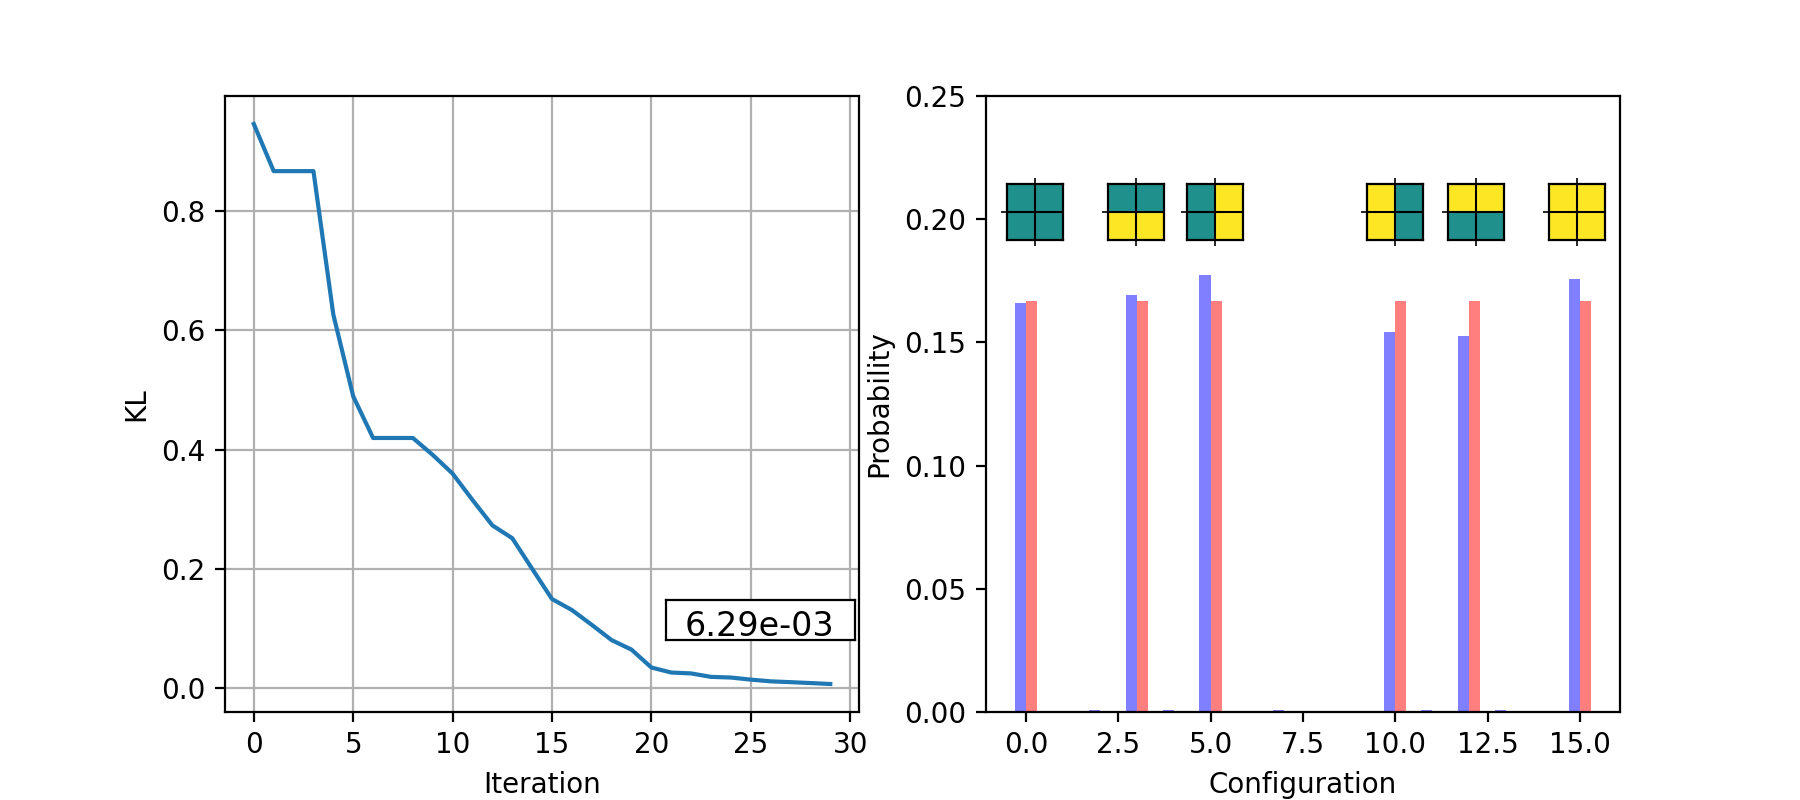

In [32]:
save_filename = 'Trial1_top-all_'
file_path = str(save_filename) + 'cost_and_angles_all.txt'
f = open(file_path, 'w')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax_c = fig.add_axes([0.37,0.2,0.105,0.05])
y_position, width, height = 0.7, 0.05, 0.07
ax_b = []
ax_b.append(fig.add_axes([0.55,y_position,width,height]))
ax_b.append(fig.add_axes([0.606,y_position,width,height]))
ax_b.append(fig.add_axes([0.65,y_position,width,height]))
ax_b.append(fig.add_axes([0.75,y_position,width,height]))
ax_b.append(fig.add_axes([0.795,y_position,width,height]))
ax_b.append(fig.add_axes([0.851,y_position,width,height]))


best_angles = []
best_costs = []
best_histogram = []
    
for i in range(n_iterations):
        
    costs       = [KL(batch[p]) for p in range(particles)]
    costs       = np.array(costs).reshape((particles,))
    
    b_angles, b_cost, _, _  = optimizer.run(costs)
    b_hist = circuit(b_angles)
    
    best_angles.append(b_angles)
    best_costs.append(b_cost)
    best_histogram.append(circuit(b_angles))   

    batch = optimizer.x
        
    f.write('%s \t' % i)
    f.write('%s \t' % b_cost)
    for item in b_angles:
        f.write("%s \t" % item)
        f.write('\n')
    
    plots(ax1,ax2,ax_b,ax_c,fig,best_costs,bas,hist_sample,b_hist,n,m)
    
    if i == 1:
        time.sleep(10) 

## Exercises:

1. Modify the code to build a circuit that outputs the distribution that gives '0000' and '1111' a probability of 0.5, and any other state a probability of 0. What are the angles of this circuit?


2. Modify the code to train a Bars and Stripes distribution with a 'line' and a 'star' topology. Which one did better among the 'line', 'star', and 'all' topology? Why do you think this happened?


3. Modify the code to create a 'cycle' topology, where the conections are between qubits (0,1), (1,2), (2,3), and (3,0). How did this one perform on the Bars and Stripes distribution?